# Connect with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Classes

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]


# Input Data Sample

Imput Pickled Data
--

In [ ]:
pickle_in = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/X_2.pickle", "rb")
X = pickle.load(pickle_in)
 
pickle_in = open("/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/Y_2.pickle", "rb")
Y = pickle.load(pickle_in)

In [ ]:
print('Data: ', len(X), len(Y))

Data:  9596 9596


Split Data into Train, Test and Validation Sets
--

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) #20% data as test and validation data

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.50, random_state=1) #10% data as test and 10% as validation data

In [ ]:
print('Train:', len(X_train), len(Y_train), '\nTest: ', len(X_test), len(Y_test), '\nValidation: ', len(X_val), len(Y_val))

Train: 7676 7676 
Test:  960 960 
Validation:  960 960


Sample Data - Train Dataset
--

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


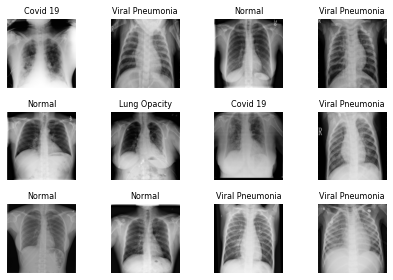

In [ ]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title[:-2], fontsize=8)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

images = {str(Classes[Y_train[i]])+format(str(i).zfill(2)): X_train[i] for i in range(12)}

display_multiple_img(images, 3, 4)

# Model Uses for Classification (VGG16)

In [ ]:
model = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
model.summary()

Add Top Layers
--

In [ ]:
inputs = model.layers[0].input

add_layer = model.layers[-1].output
add_layer = layers.Dense(128)(add_layer)
add_layer = layers.Activation('relu')(add_layer)
add_layer = layers.Dense(64)(add_layer)
add_layer = layers.Activation('relu')(add_layer)
add_layer = layers.GlobalAveragePooling2D()(add_layer)
outputs = layers.Dense(4, activation='softmax')(add_layer)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Train the model
--

In [ ]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

checkpoint_loss = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 10
model_records = model.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/10
80/80 [==============================] - 5599s 70s/step - loss: 2.1184 - accuracy: 0.2422 - val_loss: 1.3867 - val_accuracy: 0.2375

Epoch 00001: val_accuracy improved from -inf to 0.23750, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-01-performance-0.24-1.39.hdf5

Epoch 00001: val_loss improved from inf to 1.38674, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-01-performance-0.24-1.39.hdf5
Epoch 2/10
80/80 [==============================] - 5534s 69s/step - loss: 1.3888 - accuracy: 0.2565 - val_loss: 1.3898 - val_accuracy: 0.2646

Epoch 00002: val_accuracy improved from 0.23750 to 0.26458, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-02-performance-0.26-1.39.hdf5

Epoch 00002: val_loss did not improve from 1.38674
Epoch 3/10
80/80 [==============================] - 5553s 69s

Re-Training
--

In [ ]:
re_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-06-performance-0.63-0.87.hdf5')

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v2-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

checkpoint_loss = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 5
model_records = re_model.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/5
80/80 [==============================] - 7271s 91s/step - loss: 0.7054 - accuracy: 0.7031 - val_loss: 0.6975 - val_accuracy: 0.7115

Epoch 00001: val_accuracy improved from -inf to 0.71146, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v2-01-performance-0.71-0.70.hdf5

Epoch 00001: val_loss improved from inf to 0.69750, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v2-01-performance-0.71-0.70.hdf5
Epoch 2/5
80/80 [==============================] - 7274s 91s/step - loss: 0.6443 - accuracy: 0.7357 - val_loss: 0.6707 - val_accuracy: 0.7490

Epoch 00002: val_accuracy improved from 0.71146 to 0.74896, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v2-02-performance-0.75-0.67.hdf5

Epoch 00002: val_loss improved from 0.69750 to 0.67073, saving model to /content/drive/MyDrive/Data Minin

In [ ]:
re_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v2-03-performance-0.78-0.57.hdf5')

In [ ]:
filepath = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v3-{epoch:02d}-performance-{val_accuracy:.2f}-{val_loss:.2f}.hdf5'

checkpoint_acc = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

checkpoint_loss = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint_acc, checkpoint_loss]

epochs = 5
model_records = re_model.fit(X_train, Y_train, epochs=epochs, batch_size=96, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/5
80/80 [==============================] - 6629s 83s/step - loss: 0.5350 - accuracy: 0.7903 - val_loss: 0.5014 - val_accuracy: 0.8010

Epoch 00001: val_accuracy improved from -inf to 0.80104, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v3-01-performance-0.80-0.50.hdf5

Epoch 00001: val_loss improved from inf to 0.50140, saving model to /content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v3-01-performance-0.80-0.50.hdf5
Epoch 2/5
80/80 [==============================] - 6672s 83s/step - loss: 0.4677 - accuracy: 0.8145 - val_loss: 0.5195 - val_accuracy: 0.7896

Epoch 00002: val_accuracy did not improve from 0.80104

Epoch 00002: val_loss did not improve from 0.50140
Epoch 3/5
80/80 [==============================] - 6751s 84s/step - loss: 0.4179 - accuracy: 0.8439 - val_loss: 0.5005 - val_accuracy: 0.8125

Epoch 00003: val_accuracy improved from 0.80104 to 0.81250, sa

Learning Visualization
--

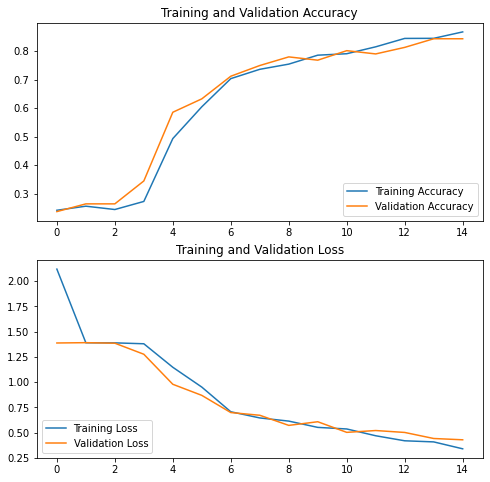

In [ ]:

train_acc = [0.2422, 0.2565, 0.2448, 0.2731, 0.4932, 0.6045, 0.7031, 0.7357, 0.7539, 0.7852, 0.7903, 0.8145, 0.8439, 0.8442, 0.8667]
val_acc = [0.2375, 0.2646, 0.2646, 0.3448, 0.5854, 0.6323, 0.7115, 0.7490, 0.7792, 0.7677, 0.8010, 0.7896, 0.8125, 0.8427, 0.8427]

train_loss = [2.1184, 1.3888, 1.3879, 1.3789, 1.1460, 0.9498, 0.7054, 0.6443, 0.6129, 0.5507, 0.5350, 0.4677, 0.4179, 0.4069, 0.3384]
val_loss = [1.3867, 1.3898, 1.3846, 1.2751, 0.9776, 0.8678, 0.6975, 0.6707, 0.5705, 0.6066, 0.5014, 0.5195, 0.5005, 0.4406, 0.4277]

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')
plt.show()

## Performance on Test Data

Import Required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Load Model
--

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v3-05-performance-0.84-0.43.hdf5')

Evaluate Model
--

In [ ]:
new_records = new_model.evaluate(X_test, Y_test)

30/30 [==============================] - 223s 7s/step - loss: 0.3902 - accuracy: 0.8604


Prediction on Unseen X-ray
--

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

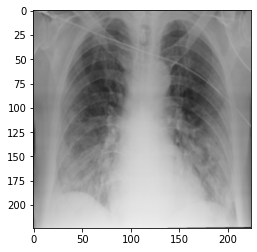

In [ ]:
img_size = 224
path = '/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Covid 19/COVID-1253.png'
data_img= cv2.imread(path, cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(data_img, cv2.COLOR_GRAY2RGB)
data_img = cv2.resize(backtorgb, (img_size, img_size))

plt.imshow(data_img)

data_img = np.array(data_img).reshape(-1, img_size, img_size, 3) 
data_img = (data_img/255.0).astype(np.float32)

In [ ]:
predictions = new_model.predict(data_img)

score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(Classes[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to Covid 19 with a 46.77 percent confidence.


# Performance Analysis

In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

In [ ]:
predictions = new_model.predict(X_test) # predict output for all test data

scores = tf.nn.softmax(predictions)
Y_pred = []
for score in scores:
  Y_pred.append(np.argmax(score))
Y_pred = np.array(Y_pred) # predicted labels

In [ ]:
Y_true = Y_test # true labels

Confusion Matrices
--

In [ ]:
# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_true, Y_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_true, Y_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Not normalized
--

Confusion Matrix


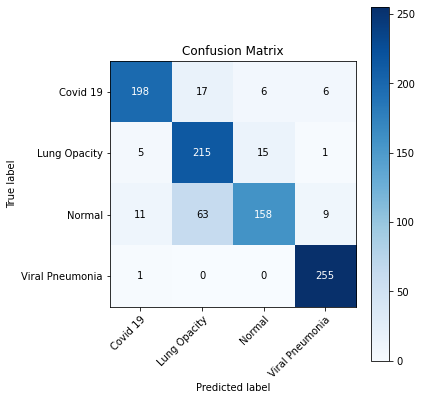

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = Classes, title='Confusion Matrix')

Normalized
--

Confusion Matrix - Normalized


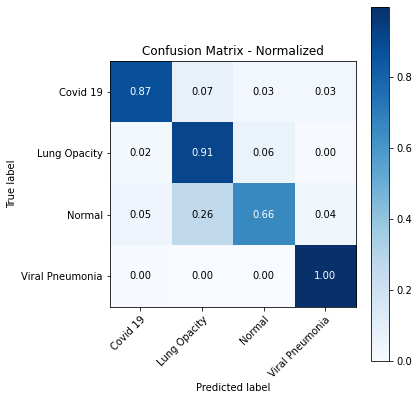

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_true, Y_pred, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

Performace Matricse
--

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_true, Y_pred)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_true, Y_pred, Classes)

Accuracy: 0.8604
Precision: 0.8694
Recall: 0.8604
F1 Score: 0.8579

Report:
                 precision    recall  f1-score   support

       Covid 19       0.92      0.87      0.90       227
   Lung Opacity       0.73      0.91      0.81       236
         Normal       0.88      0.66      0.75       241
Viral Pneumonia       0.94      1.00      0.97       256

       accuracy                           0.86       960
      macro avg       0.87      0.86      0.86       960
   weighted avg       0.87      0.86      0.86       960



ROC AUC score: 0.9061668690264676


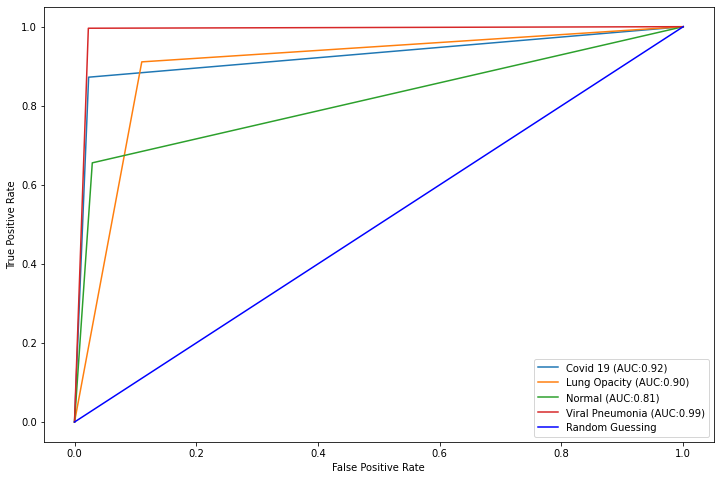

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, Y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Random Forest as Classfier of VGG16
--

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v3-05-performance-0.84-0.43.hdf5')

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
new_rf_model= tf.keras.models.Model(inputs=new_model.input, outputs=new_model.layers[-4].output)

In [ ]:
new_rf_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
features_extractor = new_rf_model.predict(X_train)

In [ ]:
features = features_extractor.reshape(features_extractor.shape[0], -1)

In [ ]:
X_rf = features

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
RF_model.fit(X_rf, Y_train)

In [ ]:
test_features_extractor = new_rf_model.predict(X_test)

In [ ]:
X_test_rf = test_features_extractor.reshape(test_features_extractor.shape[0], -1)

In [ ]:
RF_pred = RF_model.predict(X_test_rf)

In [ ]:
from sklearn import metrics
Acc = metrics.accuracy_score(Y_test, RF_pred)
print(Acc)

0.9020833333333333


In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_test, RF_pred, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_test, RF_pred)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Confusion Matrix


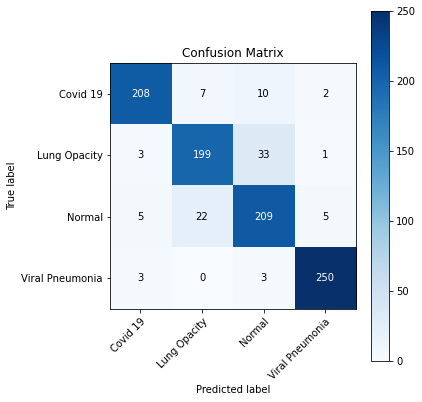

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_test, RF_pred)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, Classes = Classes, title='Confusion Matrix')

Confusion Matrix - Normalized


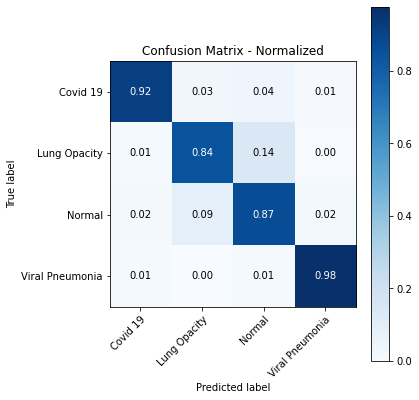

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_test, RF_pred)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_test, RF_pred, Classes)

Accuracy: 0.9021
Precision: 0.9033
Recall: 0.9021
F1 Score: 0.9024

Report:
                 precision    recall  f1-score   support

       Covid 19       0.95      0.92      0.93       227
   Lung Opacity       0.87      0.84      0.86       236
         Normal       0.82      0.87      0.84       241
Viral Pneumonia       0.97      0.98      0.97       256

       accuracy                           0.90       960
      macro avg       0.90      0.90      0.90       960
   weighted avg       0.90      0.90      0.90       960



ROC AUC score: 0.9341123577914237


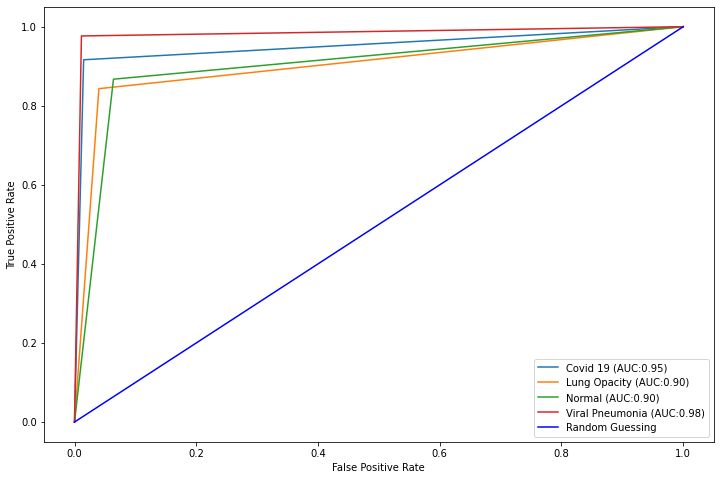

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, RF_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Random Forest without CNN as Features Extractor
--

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.callbacks import ModelCheckpoint

import cv2
import os

import matplotlib.pyplot as plt
import numpy as np

import random
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Data Mining/Project Works/Datasets/COVID_19/Pickle Data/VGG16/model-VGG16-v3-05-performance-0.84-0.43.hdf5')

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
no_cnn_model= tf.keras.models.Model(inputs=new_model.input, outputs=new_model.input)

In [ ]:
no_cnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_fe = no_cnn_model.predict(X_train)

In [ ]:
X_no_CNN = X_fe.reshape(X_fe.shape[0], -1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [ ]:
RF_model.fit(X_no_CNN, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
test_features_no_CNN = no_cnn_model.predict(X_test)

In [ ]:
X_test_no_CNN = test_features_no_CNN.reshape(test_features_no_CNN.shape[0], -1)

In [ ]:
RF_pred_no_CNN = RF_model.predict(X_test_no_CNN)

In [ ]:
from sklearn import metrics
Acc = metrics.accuracy_score(Y_test, RF_pred_no_CNN)
print(Acc)

0.79375


In [ ]:
Classes = ["Covid 19", "Lung Opacity", "Normal", "Viral Pneumonia"]

# Defining function for confusion matrix plot
def plot_confusion_matrix(Y_test, RF_pred_no_CNN, Classes, normalize=False, title=None, cmap=plt.cm.Blues):

    # Compute the confusion matrix
    conf_mat = confusion_matrix(Y_test, RF_pred_no_CNN)
    if normalize:
        conf_mat = conf_mat.astype('float32') / conf_mat.sum(axis=1)[:, np.newaxis]
        print(title)
    else:
        print(title)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(conf_mat.shape[1]), yticks=np.arange(conf_mat.shape[0]),
           xticklabels=Classes, yticklabels=Classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
   
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black")
    fig.tight_layout()

    return ax

np.set_printoptions(precision=2)

Confusion Matrix


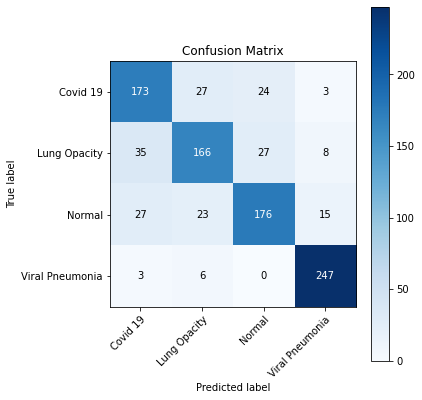

In [ ]:
from sklearn.metrics import confusion_matrix

#Plotting the confusion matrix
confusion_mtx = confusion_matrix(Y_test, RF_pred_no_CNN)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred_no_CNN, Classes = Classes, title='Confusion Matrix')

Confusion Matrix - Normalized


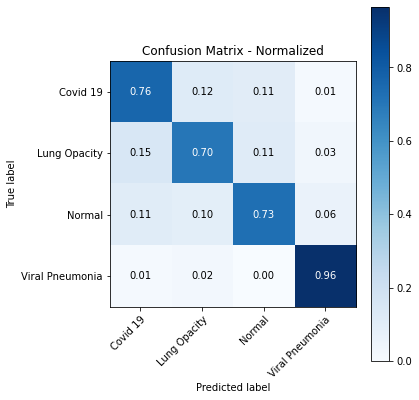

In [ ]:
#Plotting normalized confusion matrix
plot_confusion_matrix(Y_test, RF_pred_no_CNN, Classes = Classes, normalize = True, title = 'Confusion Matrix - Normalized')

In [ ]:
from sklearn import metrics

def get_metrics(true_labels, predicted_labels):
  print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
  print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'),4))
  print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
  print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))

get_metrics(Y_test, RF_pred_no_CNN)
  
def display_classification_report(true_labels, predicted_labels, Classes):
  report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=Classes)
  print("\nReport:\n"+report)

display_classification_report(Y_test, RF_pred_no_CNN, Classes)

Accuracy: 0.7938
Precision: 0.7916
Recall: 0.7938
F1 Score: 0.792

Report:
                 precision    recall  f1-score   support

       Covid 19       0.73      0.76      0.74       227
   Lung Opacity       0.75      0.70      0.72       236
         Normal       0.78      0.73      0.75       241
Viral Pneumonia       0.90      0.96      0.93       256

       accuracy                           0.79       960
      macro avg       0.79      0.79      0.79       960
   weighted avg       0.79      0.79      0.79       960



ROC AUC score: 0.8608437711124022


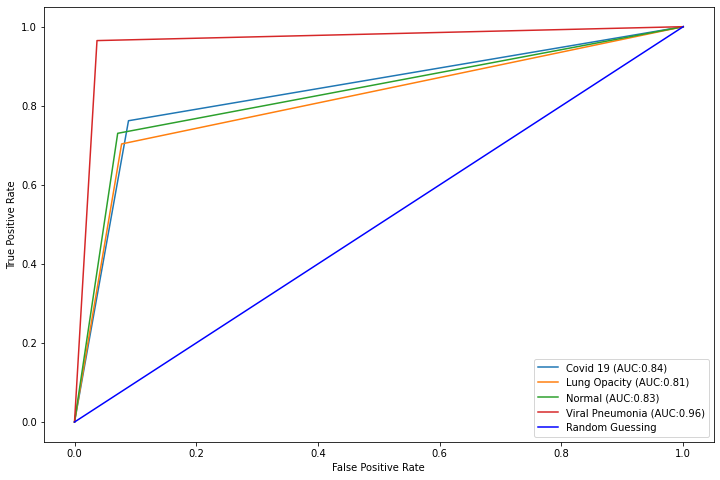

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= Classes

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  
  for (idx, c_label) in enumerate(target):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
  
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(Y_test, RF_pred_no_CNN))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()